In [1]:
%cd /home/q123/Desktop/explo

import torch 
import gpytorch 
import logging
import logging.config

from src.helpers import setup_experiment
from src.trainer import Trainer
from src.optimizers.gibo import GIBOptimizer
from src.optimizers.vanilla_bo import BOptimizer
from src.config import get_configs

logging.config.fileConfig('logging.conf')
# create root logger
logger = logging.getLogger()

/home/q123/Desktop/explo


/home/q123/miniconda3/envs/boptim/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MathLog.src.helpers : WARNING : MLP dimensions : [8, 2]


/home/q123/miniconda3/envs/boptim/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/home/q123/miniconda3/envs/boptim/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/home/q123/miniconda3/envs/boptim/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Using ard_num_dims = 18
 Gibo will use 50 last points to fit GP and 16 info samples


/home/q123/miniconda3/envs/boptim/lib/python3.10/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


current 0.05448661372065544 / max 0.19165880978107452 /batch_mean 0.04003909230232239 /batch_max 0.07657293975353241 
##############################
covar_lengthscale max 46.2387809753418 / min 46.2387809753418                      covar_outputscale 5.385577761529703e-09                     noise 0.004194941837340593
##############################
last parameters tensor([-0.1194,  0.1219,  0.1213, -0.0106,  0.0310, -0.0572,  0.0162,  0.0907,
        -0.0670,  0.1429,  0.1452, -0.0629,  0.0346,  0.0825,  0.0183,  0.0435,
        -0.1337, -0.1620])
MLL : 1.3170210123062134
grad_mean : max 1.7277035624374548e-07 /  min -2.9879939233978803e-07
grad_covar : max 9.999999717180685e-10 /  min 9.999999717180685e-10
current 0.004734292160719633 / max 0.19165880978107452 /batch_mean -0.025286540389060974 /batch_max 0.012255621142685413 
##############################
covar_lengthscale max 8.053297996520996 / min 8.053297996520996                      covar_outputscale 0.0011563737643882632       

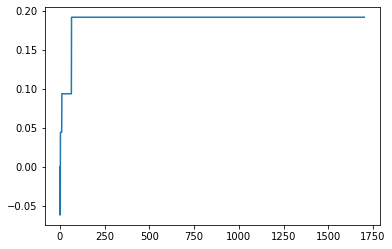

In [2]:
env_name = "Swimmer-v4"
kernel_name = "rbfstate" ## "linearstate" /"rbfstate"

env_config,likelihood_config,kernel_config,optimizer_config,trainer_config = get_configs(env_name,kernel_name)
additional_layers=[] ### can be empty or [8,7] for adding 2 layers with width 8,7 respectively


likelihood_config = {
                # "noise_hyperprior":gpytorch.priors.torch_priors.UniformPrior(a=0.01,b=0.02),
                # "noise_constraint":gpytorch.constraints.constraints.Interval(0.01,0.02)
                }

optimizer_config = {
        "n_eval":1, ## 3 for cartpole (very noisy)
        ### for GIBO
        "n_max":50, 
        "n_info_samples":16,
        "delta":0.1, ## 0.01 for cartpole
        ### hessian normalisation applies only for rbf
        "normalize_gradient":True if kernel_name == "rbf" else False,
        "standard_deviation_scaling":False,
}

kernel_config = {
        "use_ard":False,
        "kernel_name":kernel_name,
        # "lengthscale_hyperprior":gpytorch.priors.torch_priors.GammaPrior(3.0,6.0),
        # "lengthscale_constraint":gpytorch.constraints.constraints.GreaterThan(0.1),
        # "outputscale_constraint":gpytorch.constraints.constraints.GreaterThan(0.1),
        # "outputscale_hyperprior":gpytorch.priors.torch_priors.NormalPrior(loc=2.0,scale=1.0),
        }


trainer_config = {
        "n_steps":100, 
        "report_freq":5,
        "save_best":False,
}


model,objective_env = setup_experiment(env_config,kernel_config,likelihood_config,additional_layers)


### Chose optimizer 
#optimizer = BOptimizer(**optimizer_config)
optimizer = GIBOptimizer(model,**optimizer_config)
trainer = Trainer(model,objective_env,optimizer,**trainer_config)
rslt= trainer.run()